In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from sklearn import metrics

In [2]:
fast2_RBP = 'RBP201112A100|RBP201112A236|RBP201112A237|RBP201112A238'
fast25_RBP = 'RBP201112A027|RBP201112A028|RBP201112A029|RBP201112A030'
labels = ['0-0.01', '0.01-1', '1-10', '10-100', '>100']

rbp_map = {'RBP201112A100': 'RBP201112A027',
           'RBP201112A236': 'RBP201112A028',
           'RBP201112A237': 'RBP201112A029',
           'RBP201112A238': 'RBP201112A030'}

# FAST #2 vs. #2.5 Data Wrangling

In [3]:
## Data Wrangling and Covid Ratio Binning ##
df = pd.read_pickle(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle').dropna(how='all', axis=1)

df = df[(df['sample_type'] != 'NTC') & (df['sample_type'] != 'Positive')]
df = df[df['pos_tube_rack'].str.match(r'.*?(A6|B5)') == False]

df['date'] = (df.runid.str[2:4] +
              '-' + df.runid.str[4:6] +
              '-' + df.runid.str[:2]).astype(np.datetime64)
df['RBP'] = df['pos_tube_rack'].str.split(pat=':').str[0]
df['well'] = df['pos_tube_rack'].str.split(pat=':').str[1]
df['row'] = df['pos_tube_rack'].str[14]
df['column'] = df['pos_tube_rack'].str.extract(r'.*?:[A-H](\d+)').astype('int')
df['sample_count'] = 1

df['total_detected'] = df['call'].map({'not_detected': 0,
                                       'detected': 1,
                                       'no_call': np.nan})

df['category'] = pd.cut(df['median_covid_ratio'],
                        [-np.inf, 0.01, 1, 10, 100, np.inf], labels=labels)
dummies = pd.get_dummies(df.category)
df = pd.concat([df, dummies], axis=1)

## Create fast2 Extraction df ##
df_fast2 = df[df['RBP'].str.contains(fast2_RBP)].dropna(how='all', axis=1)
df_fast2['mapping'] = df_fast2.RBP.map(rbp_map)

## Create fast25 Extraction df ##
df_fast25 = df[df['RBP'].str.contains(fast25_RBP)].dropna(how='all', axis=1)

## Merge fast2 and fast25 df on RBP Mapping and Well ##
combined = pd.merge(df_fast2, df_fast25, how='outer', left_on=['mapping', 'well'], right_on=['RBP', 'well'],
                    suffixes=('_fast2', '_fast25')).sort_values(by='RBP_fast25')

# PPA/NPA

In [4]:
binning_fast2 = combined.groupby('RBP_fast2', sort=False).agg({'sample_count_fast2': 'sum',
                                                             'date_fast2': 'max',
                                                             'total_detected_fast2': 'sum',
                                                             '0-0.01_fast2': 'sum',
                                                             '0.01-1_fast2': 'sum',
                                                             '1-10_fast2': 'sum',
                                                             '10-100_fast2': 'sum',
                                                             '>100_fast2': 'sum'})
binning_fast2

,sample_count_fast2,date_fast2,total_detected_fast2,0-0.01_fast2,0.01-1_fast2,1-10_fast2,10-100_fast2,>100_fast2
RBP_fast2,,,,,,,,
RBP201112A100,92,2020-12-16,25.0,67,7,1,3,14
RBP201112A236,92,2020-12-16,14.0,78,3,2,1,8
RBP201112A237,92,2020-12-16,30.0,62,7,2,2,19
RBP201112A238,92,2020-12-16,32.0,60,5,8,6,13


In [5]:
binning_fast25 = combined.groupby('RBP_fast25', sort=False).agg({'sample_count_fast25': 'sum',
                                                             'date_fast25': 'max',
                                                             'total_detected_fast25': 'sum',
                                                             '0-0.01_fast25': 'sum',
                                                             '0.01-1_fast25': 'sum',
                                                             '1-10_fast25': 'sum',
                                                             '10-100_fast25': 'sum',
                                                             '>100_fast25': 'sum'})
binning_fast25

,sample_count_fast25,date_fast25,total_detected_fast25,0-0.01_fast25,0.01-1_fast25,1-10_fast25,10-100_fast25,>100_fast25
RBP_fast25,,,,,,,,
RBP201112A027,92,2020-12-28,25.0,67,7,1,3,14
RBP201112A028,92,2020-12-28,16.0,76,5,2,1,8
RBP201112A029,92,2020-12-28,29.0,63,5,3,2,19
RBP201112A030,92,2020-12-28,32.0,60,5,7,7,13


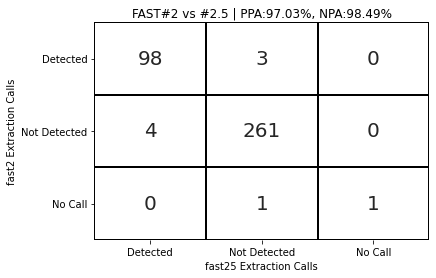

In [6]:
call_labels = ['detected', 'not_detected', 'no_call']

fast2_calls = list(combined.call_fast2.values)
fast25_calls = list(combined.call_fast25.values)

cf_matrix = metrics.confusion_matrix(fast2_calls, fast25_calls, labels=call_labels)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(['Detected', 'Not Detected', 'No Call'])
ax.set_yticklabels(['Detected', 'Not Detected', 'No Call'])
ax.set_xlabel('fast25 Extraction Calls')
ax.set_ylabel('fast2 Extraction Calls')

a,b,c,d,e,f,g,h,i = cf_matrix.ravel()

plt.title(f'FAST#2 vs #2.5 | PPA:{(a*100/(a+b+c)):.2f}%, NPA:{(e*100/(d+e+f)):.2f}%')

plt.yticks(rotation=0)
plt.show()

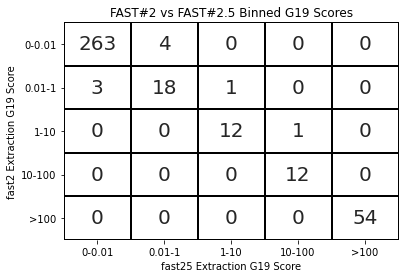

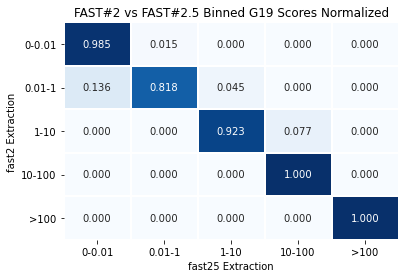

In [7]:
fast2_calls = list(combined.category_fast2.values)
fast25_calls = list(combined.category_fast25.values)

cf_matrix = metrics.confusion_matrix(fast2_calls, fast25_calls, labels=labels)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('fast25 Extraction G19 Score')
ax.set_ylabel('fast2 Extraction G19 Score')

plt.title('FAST#2 vs FAST#2.5 Binned G19 Scores')

plt.yticks(rotation=0)
plt.show()

cf_matrix = metrics.confusion_matrix(fast2_calls, fast25_calls, normalize='true')
ax2 = sns.heatmap(cf_matrix, cmap='Blues', annot=True,
                  linewidths=1, fmt='.3f', cbar=False)
ax2.set_xticklabels(labels)
ax2.set_yticklabels(labels)
ax2.set_xlabel('fast25 Extraction')
ax2.set_ylabel('fast2 Extraction')

plt.title('FAST#2 vs FAST#2.5 Binned G19 Scores Normalized')

plt.yticks(rotation=0)
plt.show()

# Plate Comparison

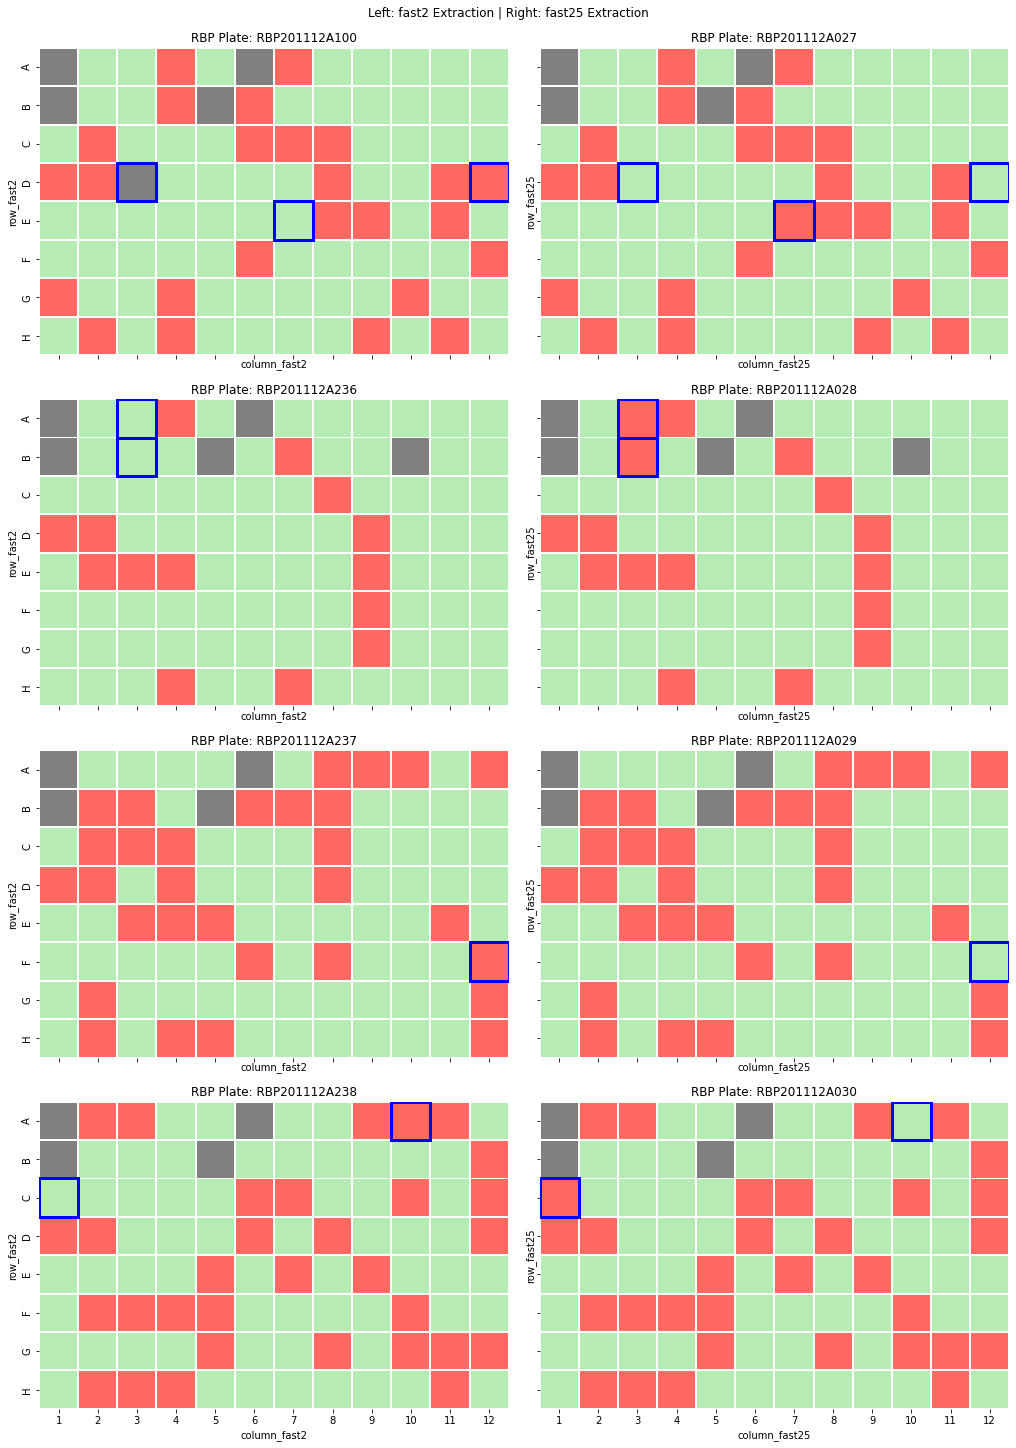

In [8]:
total_cols = 2
total_rows = 4

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, sharex=True, sharey=True,
                        figsize=(7*total_cols, 5*total_rows), constrained_layout=True, squeeze=False)

fig.suptitle(f'Left: fast2 Extraction | Right: fast25 Extraction')
fig.set_facecolor('white')
ax.tick_params(direction='out', length=6, color='black')

row_to_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
              'E': 4, 'F': 5, 'G': 6, 'H': 7}

for i, j, k in zip(combined.RBP_fast2.unique(), combined.RBP_fast25.unique(), range(4)):

    fast2 = combined[combined['RBP_fast2'] == i]
    fast2_pivot = fast2.pivot(
        index='row_fast2', columns='column_fast2', values='total_detected_fast2')
    mask_fast2 = fast2_pivot.isnull()

    fast2_fig = sns.heatmap(fast2_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][0], mask=mask_fast2, linewidths=1)
    fast2_fig.set_facecolor('grey')

    axs[k][0].set_title(f'RBP Plate: {i}')

    fast25 = combined[combined['RBP_fast25'] == j]
    fast25_pivot = fast25.pivot(
        index='row_fast25', columns='column_fast25', values='total_detected_fast25')
    mask_fast25 = fast25_pivot.isnull()

    fast25_fig = sns.heatmap(fast25_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][1], mask=mask_fast25, linewidths=1)
    fast25_fig.set_facecolor('grey')
    axs[k][1].set_title(f'RBP Plate: {j}')

    drop_fast2 = fast2[~((fast2['total_detected_fast2'].isna())
                       & (fast25['total_detected_fast25'].isna()))]
    drop_fast25 = fast25[~((fast2['total_detected_fast2'].isna())
                       & (fast25['total_detected_fast25'].isna()))]

    for i in drop_fast2[drop_fast2['total_detected_fast2'].values != drop_fast25['total_detected_fast25'].values].loc[:, ['row_fast2', 'column_fast2']].values:
        fast2_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))
        fast25_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))

# fig.savefig('fastreproducibility.png', dpi=300)

### Discordant Wells

In [9]:
drop_comb = combined[~((combined['total_detected_fast2'].isna())
                       & (combined['total_detected_fast25'].isna()))]

drop_comb[(drop_comb['total_detected_fast2'] != drop_comb['total_detected_fast25'])]\
    .loc[:, ['RBP_fast2', 'RBP_fast25', 'well', 'median_covid_ratio_fast2', 'median_covid_ratio_fast25']]

,RBP_fast2,RBP_fast25,well,median_covid_ratio_fast2,median_covid_ratio_fast25
50,RBP201112A100,RBP201112A027,E7,0.00000,0.09338
43,RBP201112A100,RBP201112A027,D12,0.03546,0.00000
34,RBP201112A100,RBP201112A027,D3,0.00000,0.00000
103,RBP201112A236,RBP201112A028,B3,0.00000,0.01020
93,RBP201112A236,RBP201112A028,A3,0.00268,0.01596
343,RBP201112A237,RBP201112A029,F12,0.13658,0.00000
204,RBP201112A238,RBP201112A030,C1,0.00000,0.03985
191,RBP201112A238,RBP201112A030,A10,0.05413,0.00000


### fast2 Covid Score vs fast25 Covid Score

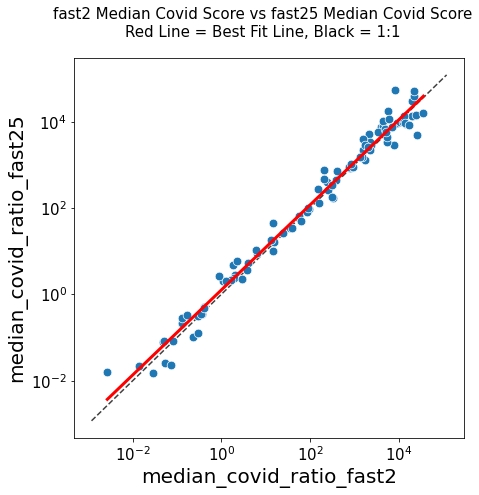

In [10]:
score_relation = combined.query("(total_detected_fast2 == 1 | total_detected_fast25 == 1) & \
                                 (median_covid_ratio_fast2 > 0 & median_covid_ratio_fast25 > 0)")

fig, ax = plt.subplots(figsize=(7, 7))
fig.set_facecolor('white')
ax.set(xscale='log', yscale='log')

sns.scatterplot(data=score_relation, x='median_covid_ratio_fast2',
                y='median_covid_ratio_fast25', s=75)

x = score_relation['median_covid_ratio_fast2'].values
y = score_relation['median_covid_ratio_fast25'].values

new_x, new_y = zip(*sorted(zip(x, y)))

logA = np.log(new_x)
logB = np.log(new_y)

m, c = np.polyfit(logA, logB, 1)
y_fit = np.exp(m*logA + c)
plt.plot(new_x, y_fit, 'r', linewidth=3)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
fig.suptitle('fast2 Median Covid Score vs fast25 Median Covid Score\n\
Red Line = Best Fit Line, Black = 1:1', fontsize=15)

plt.show()

In [11]:
## Look at Singlicate for Discordant Wells ##
singlicate = pd.read_pickle(
    "/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_read_counts.pickle")

singlicate_fast2 = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_fast2.values)].dropna(how='all', axis=1)
singlicate_fast25 = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_fast25.values)].dropna(how='all', axis=1)

singlicate_fast2['well'] = singlicate_fast2['pos_tube_rack'].str.split(
    pat=':').str[1]
singlicate_fast2['RBP'] = singlicate_fast2['pos_tube_rack'].str.split(
    pat=':').str[0]

singlicate_fast25['well'] = singlicate_fast25['pos_tube_rack'].str.split(
    pat=':').str[1]
singlicate_fast25['RBP'] = singlicate_fast25['pos_tube_rack'].str.split(
    pat=':').str[0]

## Create Table of Discordant Sample ID for fast2al and fast25 ##
drop_comb = combined[~((combined['total_detected_fast2'].isna()) & (combined['total_detected_fast25'].isna()))]
discordant = drop_comb[(drop_comb['total_detected_fast2'] != drop_comb['total_detected_fast25'])].loc[:, [
    'run_sample_id_fast2', 'run_sample_id_fast25']]

## Find Discordant Samples for fast2al and fast25 ##
single_fast2 = singlicate_fast2[singlicate_fast2['run_sample_id'].isin(discordant.run_sample_id_fast2.values)].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast2').reset_index()
single_fast25 = singlicate_fast25[singlicate_fast25['run_sample_id'].isin(discordant.run_sample_id_fast25.values)].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast25').reset_index()

## Concat Discordant Samples into one df ##
single_discord = pd.concat([single_fast2, single_fast25], axis=1).drop(columns='index')

single_discord.loc[:, ['well_fast2', 'covid_ratio_fast2', 'covid_ratio_fast25', 'replicate_call_fast2', 'replicate_call_fast25', 'RBP_fast25']]

,well_fast2,covid_ratio_fast2,covid_ratio_fast25,replicate_call_fast2,replicate_call_fast25,RBP_fast25
0,D12,0.00000,0.00000,not_detected,not_detected,RBP201112A027
1,D12,0.03546,0.00000,detected,not_detected,RBP201112A027
2,D12,0.05254,0.00000,detected,not_detected,RBP201112A027
3,D3,0.00000,0.00000,no_call,not_detected,RBP201112A027
4,D3,0.00000,0.00000,not_detected,not_detected,RBP201112A027
5,D3,0.00000,0.00000,no_call,not_detected,RBP201112A027
6,E7,0.00000,0.05375,not_detected,detected,RBP201112A027
7,E7,0.00000,0.09338,not_detected,detected,RBP201112A027
8,E7,0.04710,0.14753,detected,detected,RBP201112A027
9,A3,0.00000,0.00000,not_detected,not_detected,RBP201112A028


In [12]:
single_discord.loc[:,['well_fast2',
                      'covid_count_fast2', 'covid_count_fast25',
                      'covid_ratio_fast2', 'covid_ratio_fast25',
                      'rnase_count_fast2', 'rnase_count_fast25',
                      'spikein_count_fast2', 'spikein_count_fast25',
                      'replicate_call_fast2', 'replicate_call_fast25']]

,well_fast2,covid_count_fast2,covid_count_fast25,covid_ratio_fast2,covid_ratio_fast25,rnase_count_fast2,rnase_count_fast25,spikein_count_fast2,spikein_count_fast25,replicate_call_fast2,replicate_call_fast25
0,D12,0.0,0.0,0.00000,0.00000,895.0,1973.0,23514.0,28073.0,not_detected,not_detected
1,D12,585.0,0.0,0.03546,0.00000,1075.0,1506.0,16498.0,16622.0,detected,not_detected
2,D12,603.0,0.0,0.05254,0.00000,2112.0,393.0,11476.0,15672.0,detected,not_detected
3,D3,0.0,0.0,0.00000,0.00000,721.0,4099.0,8.0,10612.0,no_call,not_detected
4,D3,0.0,0.0,0.00000,0.00000,1786.0,2599.0,1865.0,26834.0,not_detected,not_detected
5,D3,0.0,0.0,0.00000,0.00000,1037.0,1532.0,236.0,5854.0,no_call,not_detected
6,E7,0.0,567.0,0.00000,0.05375,4672.0,8992.0,9447.0,10548.0,not_detected,detected
7,E7,0.0,1040.0,0.00000,0.09338,1796.0,1362.0,18103.0,11137.0,not_detected,detected
8,E7,2193.0,1889.0,0.04710,0.14753,1946.0,978.0,46563.0,12804.0,detected,detected
9,A3,0.0,0.0,0.00000,0.00000,4868.0,2247.0,25317.0,28784.0,not_detected,not_detected


### RNAse of No Call Wells

In [13]:
rnase_discord = combined[(combined['total_detected_fast2'].isna()) | (combined['total_detected_fast25'].isna())]

rnase_fast2 = singlicate_fast2[singlicate_fast2['run_sample_id'].isin(rnase_discord.run_sample_id_fast2.values)].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast2').reset_index()
rnase_fast25 = singlicate_fast25[singlicate_fast25['run_sample_id'].isin(rnase_discord.run_sample_id_fast25.values)].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast25').reset_index()

## Concat Discordant Samples into one df ##
rnase_discord = pd.concat([rnase_fast2, rnase_fast25], axis=1).drop(columns='index')

rnase_discord.loc[:, ['well_fast2', 'rnase_count_fast2', 'rnase_count_fast25', 'RBP_fast25']]


,well_fast2,rnase_count_fast2,rnase_count_fast25,RBP_fast25
0,D3,721.0,4099.0,RBP201112A027
1,D3,1786.0,2599.0,RBP201112A027
2,D3,1037.0,1532.0,RBP201112A027
3,B10,0.0,0.0,RBP201112A028
4,B10,0.0,0.0,RBP201112A028
5,B10,0.0,0.0,RBP201112A028


### Spikein Count of No Call Well (FAST2 RBP201112A100:D3)

In [14]:
singlicate[singlicate['pos_tube_rack'] == 'RBP201112A100:D3'].loc[:,['spikein_count', 'covid_ratio', 'replicate_call', 'replicate_flags', 'pos_tube_rack']]

,spikein_count,covid_ratio,replicate_call,replicate_flags,pos_tube_rack
43,8.0,0.0,no_call,low_covid_plus_spikein,RBP201112A100:D3
206,1865.0,0.0,not_detected,pass,RBP201112A100:D3
371,236.0,0.0,no_call,low_covid_plus_spikein,RBP201112A100:D3


# Heatmap of All FAST Runs vs Normal G19 Score

In [15]:
norm_RBP = 'RBP200828A305|RBP200828A123|RBP201022A161|RBP201022A115|RBP201112A183|RBP201112A181|RBP201112A184|RBP201112A068'
fast_RBP = 'RBP201112A039|RBP201112A040|RBP201112A041|RBP201112A176|RBP201112A100|RBP201112A236|RBP201112A237|RBP201112A238|RBP201112A027|RBP201112A028|RBP201112A029|RBP201112A030'

rbp_map = {'RBP201112A039':'RBP200828A305',
           'RBP201112A040':'RBP200828A123',
           'RBP201112A041':'RBP201022A161',
           'RBP201112A176':'RBP201022A115',
           'RBP201112A100':'RBP201112A183',
           'RBP201112A236':'RBP201112A181',
           'RBP201112A237':'RBP201112A184',
           'RBP201112A238':'RBP201112A068',
           'RBP201112A027':'RBP201112A183',
           'RBP201112A028':'RBP201112A181',
           'RBP201112A029':'RBP201112A184',
           'RBP201112A030':'RBP201112A068'}

In [16]:
## Data Wrangling and Covid Ratio Binning ##
df = pd.read_pickle(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle').dropna(how='all', axis=1)

df = df[(df['sample_type'] != 'NTC') & (df['sample_type'] != 'Positive')]
df = df[df['pos_tube_rack'].str.match(r'.*?(A6|B5)') == False]

df['date'] = (df.runid.str[2:4] +
              '-' + df.runid.str[4:6] +
              '-' + df.runid.str[:2]).astype(np.datetime64)
df['RBP'] = df['pos_tube_rack'].str.split(pat=':').str[0]
df['well'] = df['pos_tube_rack'].str.split(pat=':').str[1]
df['row'] = df['pos_tube_rack'].str[14]
df['column'] = df['pos_tube_rack'].str.extract(r'.*?:[A-H](\d+)').astype('int')
df['sample_count'] = 1

df['total_detected'] = df['call'].map({'not_detected': 0,
                                       'detected': 1,
                                       'no_call': np.nan})

df['category'] = pd.cut(df['median_covid_ratio'],
                        [-np.inf, 0.01, 1, 10, 100, np.inf], labels=labels)
dummies = pd.get_dummies(df.category)
df = pd.concat([df, dummies], axis=1)

## Create Normal Extraction df ##
df_norm = df[df['RBP'].str.contains(norm_RBP)].dropna(how='all', axis=1)

## Create FAST Extraction df ##
dropped_RBP = ['RBP201112A039', 'RBP201112A176']
dropped_wells = ['D12', 'E12', 'F12', 'G12', 'H12']

df_fast = df[df['RBP'].str.contains(fast_RBP)].dropna(how='all', axis=1)
df_fast = df_fast[~((df_fast['RBP'].isin(dropped_RBP)) &
                    (df_fast['well'].isin(dropped_wells)))]
df_fast['mapping'] = df_fast.RBP.map(rbp_map)

## Merge Normal and FAST df on RBP Mapping and Well ##
combined = pd.merge(df_norm, df_fast, how='outer', left_on=['RBP', 'well'], right_on=['mapping', 'well'],
                    suffixes=('_norm', '_fast')).sort_values(by='RBP_fast')

In [17]:
binning_norm = combined.groupby('RBP_norm', sort=False).agg({'sample_count_norm': 'sum',
                                                             'date_norm': 'max',
                                                             'total_detected_norm': 'sum',
                                                             '0-0.01_norm': 'sum',
                                                             '0.01-1_norm': 'sum',
                                                             '1-10_norm': 'sum',
                                                             '10-100_norm': 'sum',
                                                             '>100_norm': 'sum'})
binning_norm

,sample_count_norm,date_norm,total_detected_norm,0-0.01_norm,0.01-1_norm,1-10_norm,10-100_norm,>100_norm
RBP_norm,,,,,,,,
RBP201112A183,184,2020-12-05,52.0,132,14,4,4,30
RBP201112A181,184,2020-12-05,28.0,156,6,2,2,18
RBP201112A184,184,2020-12-05,58.0,126,8,8,0,42
RBP201112A068,184,2020-12-03,66.0,118,6,12,18,30
RBP200828A305,87,2020-10-20,12.0,75,2,2,0,8
RBP200828A123,92,2020-10-27,13.0,79,3,0,4,6
RBP201022A161,92,2020-11-07,12.0,80,4,5,1,2
RBP201022A115,87,2020-11-10,30.0,57,15,2,2,11


In [18]:
binning_fast = combined.groupby('RBP_fast', sort=False).agg({'sample_count_fast': 'sum',
                                                             'date_fast': 'max',
                                                             'total_detected_fast': 'sum',
                                                             '0-0.01_fast': 'sum',
                                                             '0.01-1_fast': 'sum',
                                                             '1-10_fast': 'sum',
                                                             '10-100_fast': 'sum',
                                                             '>100_fast': 'sum'})
binning_fast

,sample_count_fast,date_fast,total_detected_fast,0-0.01_fast,0.01-1_fast,1-10_fast,10-100_fast,>100_fast
RBP_fast,,,,,,,,
RBP201112A027,92,2020-12-28,25.0,67,7,1,3,14
RBP201112A028,92,2020-12-28,16.0,76,5,2,1,8
RBP201112A029,92,2020-12-28,29.0,63,5,3,2,19
RBP201112A030,92,2020-12-28,32.0,60,5,7,7,13
RBP201112A039,87,2020-12-09,12.0,75,3,1,0,8
RBP201112A040,92,2020-12-09,14.0,78,4,0,3,7
RBP201112A041,92,2020-12-09,11.0,81,4,4,1,2
RBP201112A100,92,2020-12-16,25.0,67,7,1,3,14
RBP201112A176,87,2020-12-09,29.0,58,15,2,3,9


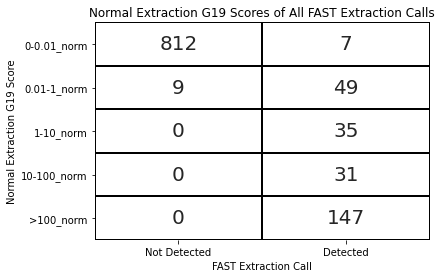

In [19]:
detected_comparison = combined.groupby('total_detected_fast').sum().iloc[:,8:13]

ax = sns.heatmap(detected_comparison.transpose(), cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='.0f',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(['Not Detected', 'Detected'])
ax.set_xlabel('FAST Extraction Call')
ax.set_ylabel('Normal Extraction G19 Score')

plt.title('Normal Extraction G19 Scores of All FAST Extraction Calls')

plt.show()

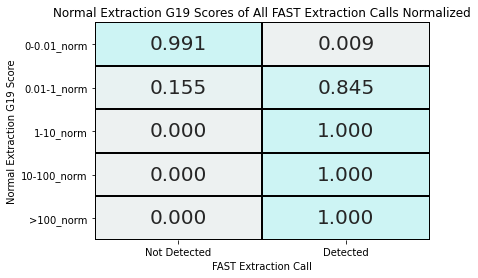

In [20]:
for i in detected_comparison:
    detected_comparison.loc[:,i] = detected_comparison[i].apply(lambda x:x/detected_comparison[i].sum())

cmap = sns.color_palette("light:#cdf4f4", as_cmap=True)

ax = sns.heatmap(detected_comparison.transpose(), cmap=cmap,
                 annot=True, annot_kws={"size": 20}, fmt='.3f',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(['Not Detected', 'Detected'])
ax.set_xlabel('FAST Extraction Call')
ax.set_ylabel('Normal Extraction G19 Score')

plt.title('Normal Extraction G19 Scores of All FAST Extraction Calls Normalized')

plt.show()

In [21]:
everything = pd.read_pickle('/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle').dropna(how='all', axis=1).query("sample_type == 'Positive'")
everything.loc[everything['pos_tube_rack'].str.contains(norm_RBP) == True, 'workflow'] = 'normal'
everything.loc[everything['pos_tube_rack'].str.contains(fast_RBP) == True, 'workflow'] = 'FAST'
everything.dropna(subset=['workflow'], inplace=True)

/home/bshih/miniconda3/envs/c19dash/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


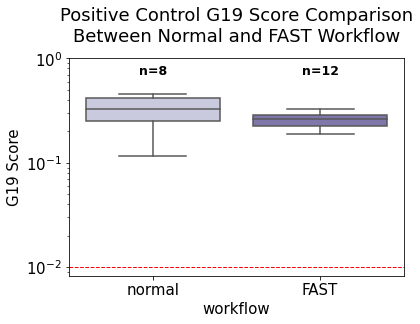

In [22]:
matplotlib.rcParams.update({'font.size': 15})

a = sns.boxplot(x='workflow', y='median_covid_ratio', data=everything, showfliers=False, palette="Purples")
a.set_yscale('log')

num_fast_pos = everything['workflow'].value_counts()[0]
num_norm_pos = everything['workflow'].value_counts()[1]
labels = [f'n={num_norm_pos}', f'n={num_fast_pos}']

for xtick in a.get_xticks():
    a.text(xtick, 0.7, labels[xtick], 
           horizontalalignment='center',size='small',color='black',weight='semibold')

plt.axhline(y=0.01, color='r', linewidth=1, ls='--')
plt.ylim(0,1)
plt.ylabel('G19 Score')

plt.title('Positive Control G19 Score Comparison\nBetween Normal and FAST Workflow', y=1.05)
plt.show()